In [1]:
import numpy as np
from pyDOE import lhs
from scipy.integrate import odeint

import matplotlib.pyplot as plt

from moonlight import *

# importing the model, the simulation function
from pancreasModel import modelPID, simulation

In [2]:
[max(max(g),thresholdUp),max(max(g),thresholdUp)]

NameError: name 'g' is not defined

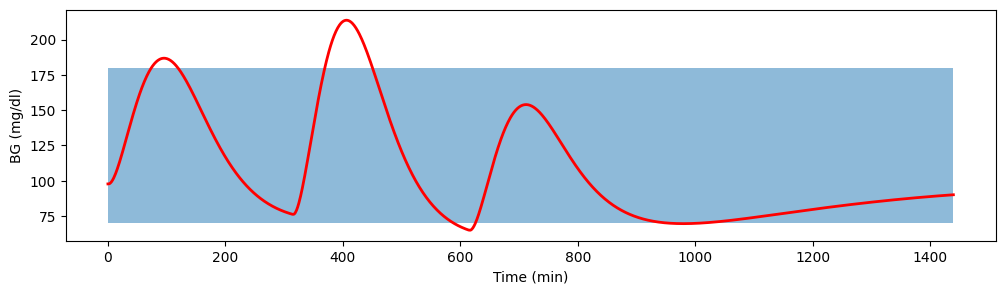

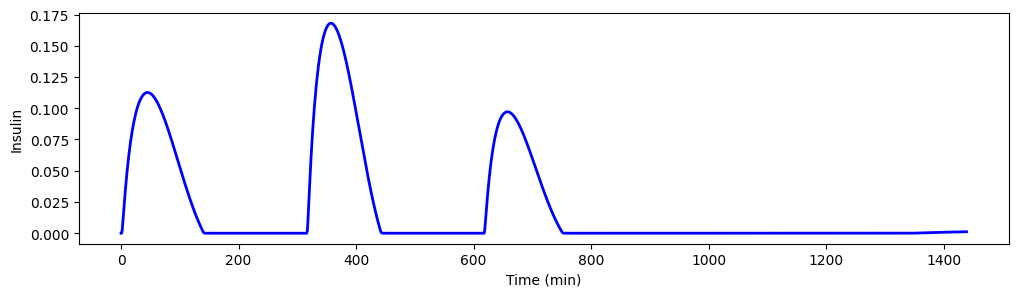

In [3]:
# setting the k_i parameters
Kd = [0, -0.0602, -0.0573, -0.06002, -0.0624]
Ki = [0, -3.53e-07, -3e-07, -1.17e-07, -7.55e-07]
Kp = [0, -6.17e-04, -6.39e-04, -6.76e-04, -5.42e-04]

pidC1 = lambda x, t: modelPID(x, t, Kp[1], Ki[1], Kd[1])
pidC2 = lambda x, t: modelPID(x, t, Kp[2], Ki[2], Kd[2])
pidC3 = lambda x, t: modelPID(x, t, Kp[3], Ki[3], Kd[3])
pidC4 = lambda x, t: modelPID(x, t, Kp[4], Ki[4], Kd[4])

pidC1Noise = lambda x, t: modelPID(x, t, Kp[1], Ki[1], Kd[1])

# defining the control parameters 
t_meal1 = np.random.normal(300, 60)
t_meal2 = np.random.normal(300, 60)
t_meal3 = 1440 - t_meal1 - t_meal2
dg1 = np.random.normal(40, 10)
dg2 = np.random.normal(90, 10)
dg3 = np.random.normal(60, 10)

# trying to vary oid constant pidC_i
t, y = simulation([t_meal1, t_meal2, t_meal3], [dg1, dg2, dg3], pidC2)
g = y[:,0]
u = y[:,-1]


# plot results
thresholdUp = 180
thresholdDown = 70

figsize = [12,3]
plt.subplots(figsize=figsize)
#plt.fill_between([t[0],t[-1]], [4,4],[max(max(g),thresholdUp),max(max(g),thresholdUp)],alpha=0.5)
plt.fill_between([t[0],t[-1]], [thresholdDown,thresholdDown],[thresholdUp,thresholdUp],alpha=0.5)
plt.plot(t,g,'r-',linewidth=2)
plt.xlabel('Time (min)')
plt.ylabel('BG (mg/dl)') # blood glucose
plt.show()

plt.subplots(figsize=figsize)
plt.plot(t,u,'b-',linewidth=2)
plt.xlabel('Time (min)')
plt.ylabel('Insulin')
plt.show()

In [4]:
g.reshape(-1,1).tolist()

[[97.77],
 [97.77],
 [97.83381336009474],
 [98.02052000387101],
 [98.32185727590549],
 [98.73006268664544],
 [99.2378368234705],
 [99.8383095395697],
 [100.52500909751309],
 [101.29183397668648],
 [102.13302708407157],
 [103.04315213432362],
 [104.01707198185836],
 [105.04992875908124],
 [106.13712558735456],
 [107.2743096923993],
 [108.45735696640921],
 [109.68235762315457],
 [110.94560295690508],
 [112.24357310798406],
 [113.57292573209628],
 [114.9304854759019],
 [116.3132342105377],
 [117.71830194485675],
 [119.14295839787698],
 [120.58460509637496],
 [122.04076805394088],
 [123.50909091023043],
 [124.98732854371157],
 [126.47334108802417],
 [127.96508833674257],
 [129.4606244949522],
 [130.9580932596625],
 [132.45572364657752],
 [133.95182467010588],
 [135.44478238819033],
 [136.93305565262656],
 [138.4151726341592],
 [139.88972749819322],
 [141.35537734351033],
 [142.81083928793691],
 [144.2548878515185],
 [145.6863523242599],
 [147.10411396526797],
 [148.5071041963305],
 [149.89

In [52]:
# defining the properties
script = """
signal {real y;}
domain minmax; 
formula below_70 = y < 70;
formula high_180 = y > 180;
formula noGood = below_70 | high_180;
formula hypoGlicemia = globally [0.0, 1400]  below_70;
formula hyperGlicemia = globally [0.0, 1400]  high_180;
formula prolonged_hyperGlicemia = eventually[0,1000]{globally [0.0, 60]  high_180};
formula prolonged_hypoGlicemia = eventually[0,1000]{globally [0.0, 30]  below_70};
"""
moonlightScript = ScriptLoader.loadFromText(script)

# monitoring the properties
monitor = moonlightScript.getMonitor("noGood")
result = np.array(monitor.monitor(t.tolist(),g.reshape(-1,1).tolist()))
print('\n','robustness:'+ str(result[0][1]),'\n') # robustness at time zero


 robustness:-27.769999999999996 



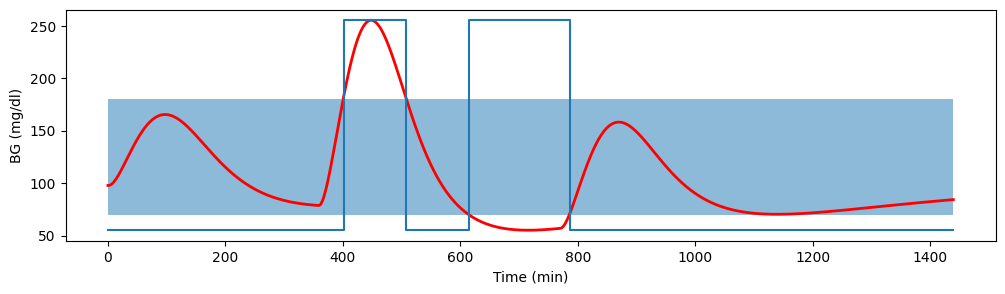

In [50]:
monitor = moonlightScript.getMonitor("noGood")
result = np.array(monitor.monitor(t.tolist(),g.reshape(-1,1).tolist()))

figsize = [12,3]
plt.subplots(figsize=figsize)
plt.fill_between([t[0],t[-1]], [thresholdDown,thresholdDown],[thresholdUp,thresholdUp],alpha=0.5)
plt.plot(t,g,'r-',linewidth=2)
rescaled_output = min(g) + (max(g)-min(g))*(1+result[:,1])/2
plt.step(result[:,0],rescaled_output, where='post')
plt.xlabel('Time (min)')
plt.ylabel('BG (mg/dl)') # blood glucose
plt.show()

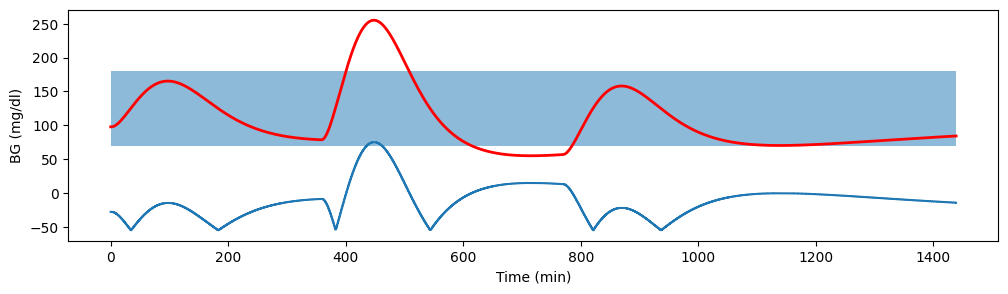

In [53]:
monitor = moonlightScript.getMonitor("noGood")
result = np.array(monitor.monitor(t.tolist(),g.reshape(-1,1).tolist()))

figsize = [12,3]
plt.subplots(figsize=figsize)
plt.fill_between([t[0],t[-1]], [thresholdDown,thresholdDown],[thresholdUp,thresholdUp],alpha=0.5)
plt.plot(t,g,'r-',linewidth=2)
plt.step(result[:,0],result[:,1], where='post')
plt.xlabel('Time (min)')
plt.ylabel('BG (mg/dl)') # blood glucose
plt.show()

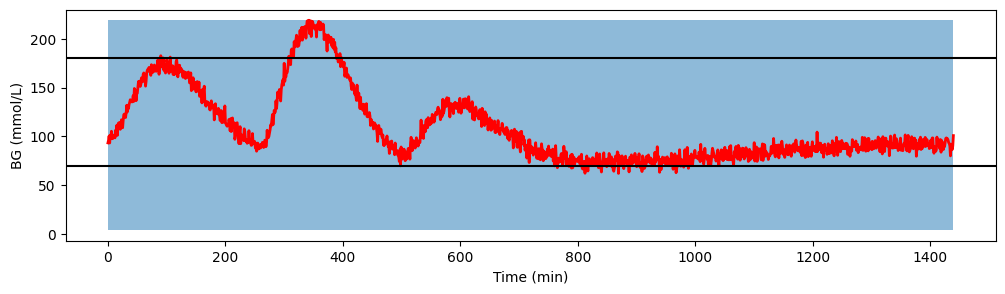


 robustness:-7.534291007702421 



In [7]:
# noise model 
y_noise = [yy+ np.random.normal(0, 5) for yy in g]

plt.subplots(figsize=figsize)
plt.fill_between([t[0],t[-1]], [4,4],[max(max(y_noise),thresholdUp),max(max(y_noise),thresholdUp)],alpha=0.5)
plt.plot(t,y_noise,'r-',linewidth=2)
plt.axhline(y=thresholdUp, color='k', linestyle='-')
plt.axhline(y=thresholdDown, color='k', linestyle='-')
plt.xlabel('Time (min)')
plt.ylabel('BG (mmol/L)')
plt.show()
y_signal = [[yy] for yy in y_noise]
result = monitor.monitor(list(t),y_signal)
print('\n','robustness:'+ str(result[0][1]),'\n') # robustness at time zero

In [54]:
#falsification
def findMinimum(pid, N):
    minSTL = float('Inf')
    vRob = float('Inf')
    for i in range(N):
        t_meal1 = np.random.normal(300, 60)
        t_meal2 = np.random.normal(300, 60)
        t_meal3 = 1440 - t_meal1 - t_meal2
        dg1 = np.random.normal(40, 10)
        dg2 = np.random.normal(90, 10)
        dg3 = np.random.normal(60, 10)
        t, y = simulation([t_meal1, t_meal2, t_meal3], [dg1, dg2, dg3], pid)
        y = y[:, 0]
        y_signal = [[yy] for yy in y]
        result = monitor.monitor(list(t),y_signal)
        stl =  result[0][1]
        if (stl < minSTL):
            minSTL = stl
            vSTL = [t_meal1, t_meal2, t_meal3, dg1, dg2, dg3]
        if minSTL < 0:
            break

    print('minSTL parameter: ' + str(vSTL))
    print('minSTL: ' + str(minSTL))

N = 100;    
findMinimum(pidC1, N)


minSTL parameter: [284.90721581030135, 352.67181913282633, 802.4209650568723, 28.48838812333605, 77.12276139049303, 59.57921259548817]
minSTL: -27.769999999999996


In [3]:
result

NameError: name 'result' is not defined